In [1]:
!date

Sun Mar  6 16:07:33 PST 2022


This is Bean Machine's [Linear Regression Tutorial](https://github.com/facebookresearch/beanmachine/blob/5ead2f65556ea8a0e420f4b54ed9fb064727889a/tutorials/Linear_Regression.ipynb).

In [2]:
from typing import Optional, Tuple

import altair
import beanmachine.ppl as bm
import pandas as pd
import sklearn.model_selection
import torch
import torch.distributions as dist


In [3]:
def make_trace_plot_for_one_parameter(
    df_samples: pd.DataFrame,
    parameter: str,
    skip_first: int,
    subsample: int,
    extent: Tuple[float, float],
    true_value: Optional[float] = None,
):
    trace = (
        altair.Chart()
        .mark_line()
        .encode(
            altair.X("draw"),
            altair.Y(parameter, scale=altair.Scale(zero=False)),
            altair.Color("chain:N"),
        )
    )
    density = (
        altair.Chart()
        .transform_density(
            density=parameter,
            bandwidth=0.1,
            groupby=["chain"],
            extent=extent,
            counts=True,
            steps=50,
        )
        .mark_line()
        .encode(
            altair.X("value:Q", title=parameter),
            altair.Y("density:Q"),
            altair.Color("chain:N"),
        )
    )
    if true_value is not None:
        density += altair.Chart().mark_rule(size=3).encode(x=altair.datum(true_value))

    return altair.hconcat(
        trace,
        density,
        data=df_samples.loc[lambda df: df["draw"] >= skip_first][::subsample],
    )


In [4]:
torch.manual_seed(12)

$$
\begin{align}
y & \sim \mathcal{N}(\beta_0 + \beta_1 x, \sigma) \\
\beta_0 & \sim \mathcal{N}(0, 10) \\
\beta_1 & \sim \mathcal{N}(0, 10) \\
\sigma & \sim \mathrm{Gamma}(1, 1) \\
\end{align}

In [5]:
altair.Chart(
    pd.DataFrame().assign(
        sigma=lambda df: torch.arange(0, 2, 0.01),
        density=lambda df: dist.Gamma(1, 1).log_prob(df["sigma"]).exp(),
    )
).mark_line().encode(x="sigma", y="density").interactive()


alt.Chart(...)

In [6]:
@bm.random_variable
def beta_0() -> bm.RVIdentifier:
    return dist.Normal(0, 10)


@bm.random_variable
def beta_1() -> bm.RVIdentifier:
    return dist.Normal(0, 10)


@bm.random_variable
def sigma() -> bm.RVIdentifier:
    return dist.Gamma(1, 1)


@bm.random_variable
def y(X: torch.Tensor) -> bm.RVIdentifier:
    return dist.Normal(beta_0() + beta_1() * X, sigma())

In [7]:
N = 200

X = dist.Normal(0, 1).expand([N, 1]).sample()
true_beta_0 = 5.
true_beta_1 = 2.
true_sigma = 1.
Y = dist.Normal(true_beta_0 + true_beta_1 * X, true_sigma).sample()

In [8]:
altair.Chart(pd.DataFrame({"X": X.squeeze(), "Y": Y.squeeze()})).mark_point().encode(
    x="X", y="Y"
)


alt.Chart(...)

In [9]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

In [10]:
observations = {y(X_train): Y_train}

In [11]:
num_samples = 2000
num_chains = 4

In [12]:
bm.seed(883355)
samples_mh = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[beta_0(), beta_1(), sigma()],
    observations=observations,
    num_samples=num_samples,
    num_chains=num_chains,
)


Samples collected: 100%|██████████| 2000/2000 [00:02<00:00, 871.41it/s]


In [13]:
bm.Diagnostics(samples_mh).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.090311,0.194321,4.853772,5.092433,5.272345,1.005951,190.860596
beta_1()[],1.867446,0.247073,1.590514,1.870549,2.282693,1.012717,182.707275
sigma()[],1.093223,0.182823,0.957207,1.069878,1.322438,1.012172,222.438995


In [14]:
df_samples = (
    samples_mh.to_xarray()
    .to_dataframe()
    .reset_index()
    .rename(columns={beta_0(): "beta_0", beta_1(): "beta_1", sigma(): "sigma"})
)


In [15]:
df_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chain   8000 non-null   int64  
 1   draw    8000 non-null   int64  
 2   beta_0  8000 non-null   float32
 3   sigma   8000 non-null   float32
 4   beta_1  8000 non-null   float32
dtypes: float32(3), int64(2)
memory usage: 218.9 KB


In [16]:
summary_chart = (
    make_trace_plot_for_one_parameter(
        df_samples,
        parameter="beta_0",
        skip_first=100,
        subsample=5,
        extent=(4.5, 5.5),
        true_value=true_beta_0,
    )
    & make_trace_plot_for_one_parameter(
        df_samples,
        parameter="beta_1",
        skip_first=100,
        subsample=5,
        extent=(1.5, 2.5),
        true_value=true_beta_1,
    )
    & make_trace_plot_for_one_parameter(
        df_samples,
        parameter="sigma",
        skip_first=100,
        subsample=5,
        extent=(0.5, 1.5),
        true_value=true_sigma,
    )
)


In [17]:
summary_chart

alt.VConcatChart(...)

# BMGInference

In [18]:
from beanmachine.ppl.inference.bmg_inference import BMGInference

In [19]:
samples_nmc = BMGInference().infer(
    queries=[beta_0(), beta_1(), sigma()],
    observations=observations,
    num_samples=2000,
    num_chains=4,
)

In [20]:
bm.Diagnostics(samples_nmc).summary()

,avg,std,2.5%,50%,97.5%,r_hat,n_eff
beta_0()[],5.085948,0.086482,4.914843,5.086256,5.255892,0.999994,6368.548828
beta_1()[],1.878027,0.088444,1.708094,1.875941,2.053633,0.999755,6862.930664
sigma()[],1.067814,0.062703,0.954429,1.064780,1.197510,0.999922,3030.358398


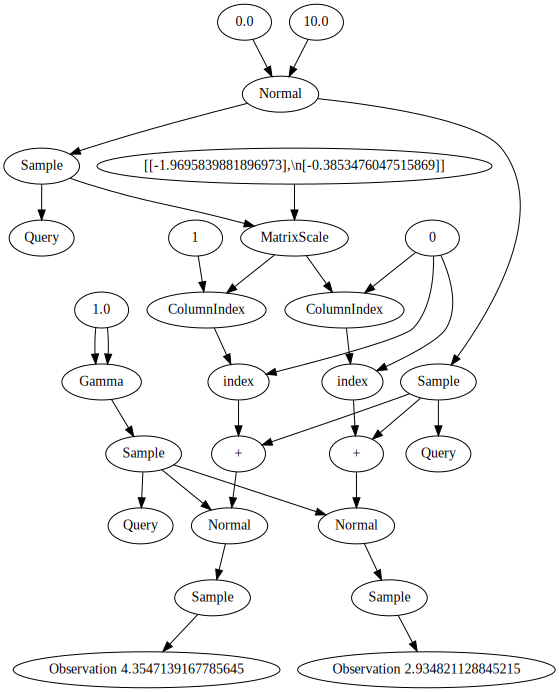

In [21]:
BMGInference().to_graphviz(
    queries=[beta_0(), beta_1(), sigma()], observations={y(X_train[:2]): Y_train[:2]}
)
